In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

#import matplotlib as mpl
#import ipympl
params_inline = {
	'axes.labelsize': 12,
	'legend.fontsize': 12,
	'xtick.labelsize': 12,
	'ytick.labelsize': 12,
	'figure.figsize': [3.5*1.2, 2.625*1.2],
	'lines.linewidth': 2,
	'scatter.edgecolors': 'black',
	'legend.numpoints': 2,
	'lines.markersize': 4,
	'ytick.major.size': 6,  # major tick size in points
	'ytick.major.width': 0.8,  # major tick width in points
	'xtick.major.size': 6,  # major tick size in points
	'xtick.major.width': 0.8,  # major tick width in points
	'axes.linewidth': 0.8,
	'figure.subplot.left': 0,
	'figure.subplot.right': 1,
	'figure.subplot.bottom': 0,
	'figure.subplot.top': 1,
	'grid.linestyle': '--',
	'axes.grid': False,
	'text.usetex': False,
	'font.family' : 'sans-serif',
	'font.sans-serif' : 'Linux Biolinum O',
	'text.latex.preamble' : r'\usepackage{libertine} \usepackage[libertine]{newtxmath} \usepackage{sfmath}',
	"xtick.direction": "in",
	"ytick.direction": "in",
	'legend.frameon': False,
	'savefig.bbox' : 'tight',
	'savefig.pad_inches' : 0.05,
    'figure.dpi' : 150,

}

_new_black = '#373737'
#_new_black = 'dimgrey'
params_nbagg = {
	'axes.labelsize': 13,
	'legend.fontsize': 13,
	'xtick.labelsize': 13,
	'ytick.labelsize': 13,
	'figure.figsize': [3.5*1.2, 2.625*1.2],
	'lines.linewidth': 2,
	'scatter.edgecolors':  _new_black,
	'legend.numpoints': 2,
	'lines.markersize': 4,
	'ytick.major.size': 6,  # major tick size in points
	'ytick.major.width': 0.8,  # major tick width in points
	'xtick.major.size': 6,  # major tick size in points
	'xtick.major.width': 0.8,  # major tick width in points
	'axes.linewidth': 0.8,
	'figure.subplot.left': 0,
	'figure.subplot.right': 1,
	'figure.subplot.bottom': 0,
	'figure.subplot.top': 1,
	'grid.linestyle': '--',
	'axes.grid': False,
	'text.usetex': False,
	'font.family' : 'sans-serif',
	'font.sans-serif' : 'Arial',
	'text.latex.preamble' : r'\usepackage{libertine} \usepackage[libertine]{newtxmath} \usepackage{sfmath}',
	"xtick.direction": "in",
	"ytick.direction": "in",
	'legend.frameon': False,
	'savefig.bbox' : 'tight',
	'savefig.pad_inches' : 0.05,
    'figure.dpi' : 150,
    
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black,

}

#params_nbagg = {}
#params_nbagg = params_inline
matplotlib.use('nbAgg')
matplotlib.rcParams.update(params_nbagg)

def hide_elements():
    css_code = """
    <style>
    .output_wrapper button.btn.btn-default,
    .output_wrapper .ui-dialog-titlebar{
      display: none;
    }
    </style>
    """
    display(HTML(css_code))
hide_elements()


In [2]:
import threading
import time
import numpy as np
import queue

class LaserStabilizer(threading.Thread):
    """
    stablize laser
    
    >>> laser_stable = LaserStabilizer()
    >>> laser_stable.start()
    >>> laser_stable.set_wavelength(1)
    >>> laser_stable.is_ready
    True
    >>> laser_stable.stop()
    
    or 
    
    >>> with laser_stable = LaserStabilizer():
    >>>    something
    
    """
    def __init__(self):
        super().__init__()
        self.is_ready = False
        self.wavelength = None
        self.desired_wavelength = None
        self.is_running = True
        self.is_change = False
        # indicate if wavelnegth has changed
        self.daemon = True
        # will be killed if main thread is killed
        
    def set_wavelength(self, desired_wavelength):
        if self.desired_wavelength != desired_wavelength:
            #print('set', desired_wavelength, 'time', time.time())
            self.is_ready = False
            self.desired_wavelength = desired_wavelength
            
        # make sure no unexpected order
                
    
    def run(self):
        while self.is_running:
            
            if self.wavelength!=self.desired_wavelength:
                self.is_change = True
                self.wavelength = self.desired_wavelength
                self.is_ready = False
                
            if self.wavelength == None:
                continue

                
            time.sleep(0.1)
            
            if self.is_change:
                #print('ready', self.wavelength, 'time', time.time())
                # only change flags after wavelength changes
                self.is_ready = True
                self.is_change = False

    def stop(self):
        if self.is_alive(): #use () cause it's a method not property
            self.is_running = False
            self.join()
        
        
    # below __enter__ and __exit__ allow class be called using with
    # 
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.stop()

In [3]:
class PLEAcquire(threading.Thread):
    """
    class for ple measurement
    """
    def __init__(self, exposure, data_x, data_y, center, height, width, bg):
        super().__init__()
        self.exposure = exposure
        self.data_x = data_x
        self.data_y = data_y
        self.center = center
        self.height = height
        self.width = width
        self.bg = bg
        self.daemon = True
        self.is_running = True
        self.is_done = False
        self.laser_stabilizer = LaserStabilizer()
        
    
    def run(self):
        
        #self.laser_stabilizer = LaserStabilizer()
        self.laser_stabilizer.start()
        
        for i, wavelength in enumerate(self.data_x):
            #print('wavelength', wavelength)
            self.laser_stabilizer.set_wavelength(wavelength)
            while self.is_running:
                time.sleep(0.1)
                if self.laser_stabilizer.is_ready:
                    break
            else:
                return 

            time.sleep(self.exposure)
            counts = np.random.poisson(self.exposure*self.height*1/((wavelength-self.center)**2/(self.width/2)**2+1) \
                                       + self.bg)

            self.data_y[i] += counts
        
        #print('be fore set is_done', self.is_done)
        self.is_done = True
        #print('after set is_done', self.is_done)
        #finish all data
        
    def stop(self):
        if self.laser_stabilizer.is_alive():
            self.laser_stabilizer.stop()
        #self.is_running = False
        if self.is_alive():
            self.is_running = False
            self.join()
        
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        #print('exit')
        self.stop()
        
        
class PLAcquire(threading.Thread):
    """
    class for pl measurement
    
    data_x, data_y, center are coordinates
    
    data_z is returned data
    
    wavelength=None as default
    
    """
    def __init__(self, exposure, data_x, data_y, data_z, center, height, wavelength=None):
        super().__init__()
        self.exposure = exposure
        self.data_x = data_x
        self.data_y = data_y
        self.data_z = data_z
        self.center = center
        self.height = height
        
        self.wavelength = wavelength
        if self.wavelength is None:
            self.is_stable = False
        else:
            self.is_stable = True
        
        self.daemon = True
        self.is_running = True
        self.is_done = False
        
    
    def run(self):
        
        if self.is_stable:
            self.laser_stabilizer = LaserStabilizer()
            self.laser_stabilizer.start()
            self.laser_stabilizer.set_wavelength(self.wavelength)
            
            while self.is_running:
                time.sleep(0.1)
                if self.laser_stabilizer.is_ready:
                    break
        
        for j, y in enumerate(self.data_y):
            for i, x in enumerate(self.data_x):
                # reverse x, y order because how imshow displays data
                if not self.is_running:
                    return
                # break loop when interrupt
                
                time.sleep(self.exposure)
                counts = np.random.poisson(self.height)

                self.data_z[j][i] += counts
            
        self.is_done = True
        #finish all data
        
    def stop(self):
        
        if self.is_stable:
            self.laser_stabilizer.stop()
            
        self.is_running = False
        self.join()
        
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        #print('exit')
        self.stop()
        
        
class LiveAcquire(threading.Thread):
    """
    class for live counts measurement
    
    data_x means time/points
    
    data_y is returned data, and rolled by LiveAcquire
    
    wavelength=None as default
    
    """
    def __init__(self, exposure, data_x, data_y, height, wavelength=None, is_finite=False):
        super().__init__()
        self.exposure = exposure
        self.data_x = data_x
        self.data_y = data_y
        self.height = height
        
        self.wavelength = wavelength
        if self.wavelength is None:
            self.is_stable = False
        else:
            self.is_stable = True
        self.is_finite = is_finite
        
        self.daemon = True
        self.is_running = True
        self.is_done = False
        
    
    def run(self):
        
        if self.is_stable:
            self.laser_stabilizer = LaserStabilizer()
            self.laser_stabilizer.start()
            self.laser_stabilizer.set_wavelength(self.wavelength)
            
            while self.is_running:
                time.sleep(0.1)
                if self.laser_stabilizer.is_ready:
                    break
        
        
        counter = 0
        while 1 and counter<len(self.data_x):

            if not self.is_running:
                return
            # break loop when interrupt

            if self.is_finite:
                counter += 1
            # roll data as live counts, from left most to right most, [:] makes sure not create new arr

            time.sleep(self.exposure)
            counts = np.random.poisson(self.height)

            self.data_y[:] = np.roll(self.data_y, 1)
            self.data_y[0] = counts
            #print(counts, self.data_y)
            
        self.is_done = True
        #finish all data
        
    def stop(self):
        
        if self.is_stable:
            self.laser_stabilizer.stop()
            
        self.is_running = False
        self.join()
        
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        #print('exit')
        self.stop()

In [4]:
from matplotlib.widgets import RectangleSelector            
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import matplotlib
import numpy as np
import time

class LivePlotGUI():
    """
    if mode is 'PLE' or 'Live'
    labels = [xlabel, ylabel]
    data = [data_x, data_y]
    
    if mode is 'PL'
    labels = [xlabel, ylabel, zlabel]
    data = [data_x, data_y, data_z] # data_z n*m array, data_z[x, y] has coordinates (x, y)
    """
    
    def __init__(self, labels, update_time, data_generator, data, fig=None):
        #VALID_MODES = ['PLE', 'PL', 'Live','PLGUI']
        #if mode not in VALID_MODES:
        #    print('mode error')
        #self.mode = mode
        
        if len(data) == 3: #PL
            self.xlabel = labels[0]
            self.ylabel = labels[1]
            self.zlabel = labels[2]
            self.data_x = data[0]
            self.data_y = data[1]
            self.data_z = data[2]
            
        else:# 'PLE' or 'Live'
            self.xlabel = labels[0]
            self.ylabel = labels[1]
            self.data_x = data[0]
            self.data_y = data[1]
        
        self.update_time = update_time
        self.data_generator = data_generator
        self.ylim_max = 100
        self.fig = fig
        if fig is None:
            self.have_init_fig = False
        else:
            self.have_init_fig = True
        
    def init_figure_and_data(self):
        #print('start')
        get_ipython().run_line_magic('matplotlib', 'nbagg')
        matplotlib.rcParams.update(params_nbagg)
        hide_elements()
        # make sure environment enables interactive then updating figure
        
        if self.fig is None:
            plt.close() # close possible previous figures
            self.fig = plt.figure()  # figsize
            #fig.tight_layout()
            self.axes = self.fig.add_subplot(111)
        else:
            #plt.close()
            #fig = self.fig
    
            self.axes = self.fig.axes[0]
            #self.fig.tight_layout()
            
        self.clear_all() #makes sure no residual artist
        self.axes.set_autoscale_on(True)
        
        #self.fig.clear()
        #self.fig.canvas.draw()
        #self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
        self.init_core()
            
        self.ylim_max = 100
        #self.canvas =  fig.canvas?
        
        
        #formatter = mticker.ScalarFormatter(useMathText=True)
        #self.axes.xaxis.set_major_formatter(formatter)
        #self.axes.xaxis.offsetText.set_visible(False)
        
        
            
        
        #axes.draw_artist(line)
        #fig.canvas.blit(fig.bbox)
        
        
        #self.fig.canvas.draw()
        #fig.show()
        #ticks_offset = self.axes.xaxis.get_major_formatter().get_offset()
        self.axes.set_ylabel(self.ylabel)
        self.axes.set_xlabel(self.xlabel)
        
        if not self.have_init_fig:
            self.fig.tight_layout()
        self.fig.canvas.draw()
        self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)  # store bg

        
        
        self.data_generator.start()
        #return self.fig
        
    def update_figure(self):
        #print(self.data_z)
        self.update_core()
            

        self.axes.draw_artist(self.line)
        self.fig.canvas.blit(self.fig.bbox)
        self.fig.canvas.flush_events()
        
        
    def init_core(self):
        raise NotImplementedError("Subclasses should implement this method.")
        
    def update_core(self):
        raise NotImplementedError("Subclasses should implement this method.")
        
    def choose_selector(self):
        raise NotImplementedError("Subclasses should implement this method.")
        
    def plot(self):
        self.init_figure_and_data()
        
        try:
            while not self.data_generator.is_done:
                self.update_figure()
                time.sleep(self.update_time)
            else:
                self.update_figure()
                #print(self.data_z)
                
        except BaseException as e:
            print(e)
            pass
        
        self.data_generator.stop()
        
        
        self.line.set_animated(False)
        #self.fig.canvas.draw()
        #self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
        #self.fig.canvas.restore_region(self.bg_fig)
        #self.axes.draw_artist(self.line)
        
        
        self.axes.set_autoscale_on(False)
        

        self.selector = self.choose_selector()

        #get_ipython().run_line_magic('matplotlib', 'inline')
        #matplotlib.rcParams.update(params_inline)
        return self.fig, self.selector

    
    def stop(self):
        #plt.close()
        if self.data_generator.is_alive():
            self.data_generator.stop()
            
    def clear_all(self):
        for ax in self.fig.axes:
            lines_to_remove = [line for line in ax.lines]
            patches_to_remove = [patch for patch in ax.patches]
            texts_to_remove = [text for text in ax.texts]


            for line in lines_to_remove:
                line.remove()
            for patch in patches_to_remove:
                patch.remove()
            for text in texts_to_remove:
                text.remove()

        self.fig.canvas.draw()
            
            
            
class PLELive(LivePlotGUI):
    
    def init_core(self):
        
        self.line, = self.axes.plot(self.data_x, self.data_y, animated=True, color='grey', alpha=0.7)
        self.axes.set_xlim(np.min(self.data_x), np.max(self.data_x))
        #self.fig.tight_layout()
        
    def update_core(self):
        if len(self.data_y) == 0:
            max_data_y = 0
        else:
            max_data_y = np.max(self.data_y)
        
        if not 100 < (self.ylim_max - max_data_y) < 1000:
            self.ylim_max = max_data_y + 500
            self.axes.set_ylim(0, self.ylim_max)

            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)  # update ylim so need redraw

        self.fig.canvas.restore_region(self.bg_fig)
        self.line.set_ydata(self.data_y)
        
    def choose_selector(self):
        self.area = AreaSelector(self.fig.axes[0])
        self.cross = CrossSelector(self.fig.axes[0])
        self.zoom = ZoomPan(self.fig.axes[0])
        
        return [self.area, self.cross, self.zoom]
        

class PLLive(LivePlotGUI):
    
    def init_core(self):
        
        cmap_ = matplotlib.cm.get_cmap('inferno')
        cmap = cmap_.copy()
        cmap.set_under(cmap_(0))
        half_step_x = 0.5*(self.data_x[-1] - self.data_x[0])/len(self.data_x)
        half_step_y = 0.5*(self.data_y[-1] - self.data_y[0])/len(self.data_y)
        extents = [self.data_x[0]-half_step_x, self.data_x[-1]+half_step_x, \
                   self.data_y[-1]+half_step_y, self.data_y[0]-half_step_y] #left, right, bottom, up
        self.line = self.axes.imshow(self.data_z, animated=True, alpha=0.7, cmap=cmap, extent=extents)
        #self.fig.tight_layout()
        cbar = self.fig.colorbar(self.line)
        cbar.set_label(self.zlabel)

        self.vmin = 0
        self.vmax = 0
            
        
    def update_core(self):
        
        if np.max(self.data_z)==0:
            vmin = 0
        else:
            vmin = np.min(self.data_z[self.data_z!=0])

        vmax = np.max(self.data_z)
        if vmin*0.8 < self.vmin or self.vmax < vmax*1.2:
            self.vmin = vmin*0.8
            self.vmax = vmax*1.2
        # filter out zero data

            self.line.set_clim(vmin=vmin, vmax=np.max(self.data_z))
            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)


        self.fig.canvas.restore_region(self.bg_fig)
        self.line.set_array(self.data_z)
        
    def choose_selector(self):
        self.area = AreaSelector(self.fig.axes[0])
        self.cross = CrossSelector(self.fig.axes[0])
        self.zoom = ZoomPan(self.fig.axes[0])
        
        return [self.area, self.cross, self.zoom]

from mpl_toolkits.axes_grid1 import make_axes_locatable
class PLDisLive(LivePlotGUI):

    def init_core(self):
        width, height = self.fig.get_size_inches()
        self.fig.set_size_inches(width, height*1.25)
        
        cmap_ = matplotlib.cm.get_cmap('inferno')
        cmap = cmap_.copy()
        cmap.set_under(cmap_(0))
        half_step_x = 0.5*(self.data_x[-1] - self.data_x[0])/len(self.data_x)
        half_step_y = 0.5*(self.data_y[-1] - self.data_y[0])/len(self.data_y)
        extents = [self.data_x[0]-half_step_x, self.data_x[-1]+half_step_x, \
                   self.data_y[-1]+half_step_y, self.data_y[0]-half_step_y] #left, right, bottom, up
        self.line = self.axes.imshow(self.data_z, animated=True, alpha=0.7, cmap=cmap, extent=extents)

        self.vmin = 0
        self.vmax = 0
        self.counts_max = 5
        
        
        divider = make_axes_locatable(self.axes)
        self.axright = divider.append_axes("top", size="20%", pad=0.25)
        
        if np.max(self.data_z.flatten()) == 0:
            hist_data = [0, 0]
        else:
            hist_data = [i for i in self.data_z.flatten() if i != 0]
        self.n, self.bins, self.patches = self.axright.hist(hist_data, orientation='vertical', bins=30, color='grey')
        self.axright.set_ylim(0, self.counts_max)
        self.cax = divider.append_axes("right", size="5%", pad=0.15)
        cbar = self.fig.colorbar(self.line, cax = self.cax)
        cbar.set_label(self.zlabel)
        #self.fig.tight_layout()
        
        #self.fig.canvas.draw()
        #self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
        
    def update_core(self):
        
        if np.max(self.data_z.flatten()) == 0:
            self.hist_data = [0, 0]
            vmin = 0
            vmax = np.max(self.data_z) + 1
        else:
            vmin = np.min(self.data_z[self.data_z!=0])
            vmax = np.max(self.data_z)
            self.hist_data = [i for i in self.data_z.flatten() if i != 0]

        self.n, _ = np.histogram(self.hist_data, bins=self.bins)

        
        #vmax = np.max(self.data_z)
        if vmin*0.8 < self.vmin or self.vmax < vmax*1.2:
            #print('v')
            self.vmin = vmin*0.8
            self.vmax = vmax*1.2
        # filter out zero data

            self.line.set_clim(vmin=vmin, vmax=vmax)
            
            self.n, self.bins, self.patches = self.axright.hist(self.hist_data, orientation='vertical', 
                                                                bins=30, color='grey')
            self.counts_max = np.max(self.n) + 5
            self.axright.set_ylim(0, self.counts_max)
            self.axright.set_xlim(vmin - (vmax-vmin)*0.1, vmax + (vmax-vmin)*0.1)
            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
            
        elif np.max(self.n) >= self.counts_max:
            #print('max n')
            self.counts_max = np.max(self.n) + 5
            self.axright.set_ylim(0, self.counts_max)
            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)


        self.fig.canvas.restore_region(self.bg_fig)
        self.line.set_array(self.data_z)
        
        #print(self.n, self.bins)
        for count, patch in zip(self.n, self.patches):
            patch.set_height(count)
            #patch.set_width(0.5)
        
        self.axright.draw_artist(self.axright.patch)
        for patch in self.patches:
            self.axright.draw_artist(patch)
            
        #print(hist_data, np.min(hist_data), np.max(hist_data))
        #self.axright.clear()
        #self.axright.hist(hist_data, orientation='vertical', bins=30, color='grey')
        #self.axright.set_xlim(vmin, vmax)
        #print(vmin, np.max(self.data_z))
        #self.fig.canvas.draw()
        
    def choose_selector(self):
        self.area = AreaSelector(self.fig.axes[0])
        self.cross = CrossSelector(self.fig.axes[0])
        self.zoom = ZoomPan(self.fig.axes[0])
        
        cmap = self.axes.images[0].colorbar.mappable.get_cmap()
        self.line_l = self.axright.axvline(np.min(self.hist_data), color=cmap(0))
        self.line_h = self.axright.axvline(np.max(self.hist_data), color=cmap(0.95))
        self.drag_line = DragVLine(self.line_l, self.line_h, self.update_clim, self.axright)
        #self.drag_line_h = DragVLine(self.line_h, self.update_clim, self.axright)
        
        return [self.area, self.cross, self.zoom, self.drag_line]
    
    def update_clim(self):
        vmin = self.line_l.get_xdata()[0]
        vmax = self.line_h.get_xdata()[0]
        self.line.set_clim(vmin, vmax)
        #self.fig.canvas.draw()

class PLGUILive(LivePlotGUI):
    
    def init_core(self):
    
        self.cbar = self.fig.axes[0].images[0].colorbar
        self.axright = self.fig.axes[1]
        self.cax = self.fig.axes[2]
        
        cmap_ = matplotlib.cm.get_cmap('inferno')
        cmap = cmap_.copy()
        cmap.set_under(cmap_(0))
        half_step_x = 0.5*(self.data_x[-1] - self.data_x[0])/len(self.data_x)
        half_step_y = 0.5*(self.data_y[-1] - self.data_y[0])/len(self.data_y)
        extents = [self.data_x[0]-half_step_x, self.data_x[-1]+half_step_x, \
                   self.data_y[-1]+half_step_y, self.data_y[0]-half_step_y] #left, right, bottom, up
        #print('first',self.data_z)
        #line = axes.imshow(self.data_z, animated=True, alpha=0.7, cmap=cmap, extent=extents)
        self.line = self.fig.axes[0].images[0]
        self.line.set(cmap = cmap, extent=extents)
        self.line.set_array(self.data_z)

        self.cbar.update_normal(self.line)
        self.cbar.set_label(self.zlabel)
        
        self.counts_max = 5
        self.vmin = 0
        self.vmax = 0
        # filter out zero data

        
        if np.max(self.data_z.flatten()) == 0:
            hist_data = [0, 0]
        else:
            hist_data = [i for i in self.data_z.flatten() if i != 0]
        self.n, self.bins, self.patches = self.axright.hist(hist_data, orientation='vertical', bins=30, color='grey')
        self.axright.set_ylim(0, self.counts_max)
        #self.fig.tight_layout()
        
        #self.fig.canvas.draw()
        #self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
        
        
    def update_core(self):
        if np.max(self.data_z.flatten()) == 0:
            self.hist_data = [0, 0]
            vmin = 0
            vmax = np.max(self.data_z) + 1
        else:
            vmin = np.min(self.data_z[self.data_z!=0])
            vmax = np.max(self.data_z)
            self.hist_data = [i for i in self.data_z.flatten() if i != 0]

        self.n, _ = np.histogram(self.hist_data, bins=self.bins)

        
        #vmax = np.max(self.data_z)
        if vmin*0.8 < self.vmin or self.vmax < vmax*1.2:
            #print('v')
            self.vmin = vmin*0.8
            self.vmax = vmax*1.2
        # filter out zero data

            self.line.set_clim(vmin=vmin, vmax=vmax)
            
            self.n, self.bins, self.patches = self.axright.hist(self.hist_data, orientation='vertical', 
                                                                bins=30, color='grey')
            self.counts_max = np.max(self.n) + 5
            self.axright.set_ylim(0, self.counts_max)
            self.axright.set_xlim(vmin - (vmax-vmin)*0.1, vmax + (vmax-vmin)*0.1)
            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)
            
        elif np.max(self.n) >= self.counts_max:
            #print('max n')
            self.counts_max = np.max(self.n) + 5
            self.axright.set_ylim(0, self.counts_max)
            self.fig.canvas.draw()
            self.bg_fig = self.fig.canvas.copy_from_bbox(self.fig.bbox)


        self.fig.canvas.restore_region(self.bg_fig)
        self.line.set_array(self.data_z)
        
        #print(self.n, self.bins)
        for count, patch in zip(self.n, self.patches):
            patch.set_height(count)
            #patch.set_width(0.5)
        
        self.axright.draw_artist(self.axright.patch)
        for patch in self.patches:
            self.axright.draw_artist(patch)
        
    def choose_selector(self):
        self.area = AreaSelector(self.fig.axes[0])
        self.cross = CrossSelector(self.fig.axes[0])
        self.zoom = ZoomPan(self.fig.axes[0])
        
        cmap = self.axes.images[0].colorbar.mappable.get_cmap()
        self.line_l = self.axright.axvline(np.min(self.hist_data), color=cmap(0))
        self.line_h = self.axright.axvline(np.max(self.hist_data), color=cmap(0.95))
        self.drag_line = DragVLine(self.line_l, self.line_h, self.update_clim, self.axright)
        #self.drag_line_h = DragVLine(self.line_h, self.update_clim, self.axright)
        
        return [self.area, self.cross, self.zoom, self.drag_line]
    
    def update_clim(self):
        vmin = self.line_l.get_xdata()[0]
        vmax = self.line_h.get_xdata()[0]
        self.line.set_clim(vmin, vmax)
        #self.fig.canvas.draw()
        
            
from decimal import Decimal            
class AreaSelector():
    def __init__(self, ax):
        self.ax = ax
        self.text = None
        self.range = [None, None, None, None]
        artist = ax.get_children()[0]
        if isinstance(artist, matplotlib.image.AxesImage):
            cmap = ax.images[0].colorbar.mappable.get_cmap()
            self.color = cmap(0.95)
        else:
            self.color = 'grey'
            
        self.selector = RectangleSelector(ax, self.onselect, interactive=True, useblit=False, button=[1], 
                                          props=dict(alpha=0.8, fill=False, 
                                                     linestyle='-', color=self.color)) 
        #set blit=True has weird bug, or implement this myself
        
    
        
    def get_decimal_places(self, value):
        non_zero = {'1', '2', '3', '4', '5', '6', '7', '8', '9'}
        value_str = str(Decimal(value))

        if '.' in value_str:
            int_str, float_str = value_str.split('.')

            if any(num in non_zero for num in int_str):
                return 0

            decimal = 0
            for num_str in float_str:
                decimal += 1
                if num_str in non_zero:
                    return decimal
        else:
            return 0

        
    def onselect(self, eclick, erelease):
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        
        if x1 == x2 or y1 == y2:
            self.range = [None, None, None, None]
            if self.text is not None:
                self.text.remove()
                self.text = None
            self.ax.figure.canvas.draw()
            return
        
        self.range = [min(x1, x2), max(x1, x2), min(y1, y2), max(y1, y2)]
        
        
        x_data = self.ax.lines[0].get_xdata()
        y_data = self.ax.lines[0].get_ydata()
        self.gap_x = np.abs(np.max(x_data) - np.min(x_data))/1000
        self.gap_y = np.abs(np.max(y_data) - np.min(y_data))/1000
        
        
        decimal_x = self.get_decimal_places(self.gap_x)
        decimal_y = self.get_decimal_places(self.gap_y)
        
        format_str = f'{{:.{decimal_x}f}}, {{:.{decimal_y}f}}'
        
        if self.text is None:
            self.text = self.ax.text(0.025, 0.975, f'({format_str.format(x1, y1)})\n({format_str.format(x2, y2)})',
                    transform=self.ax.transAxes,
                    color=self.color, ha = 'left', va = 'top'
                    )
        else:
            self.text.set_text(f'({format_str.format(x1, y1)})\n({format_str.format(x2, y2)})')

        self.ax.figure.canvas.draw()
        
    def set_active(self, active):
        if not active:
            self.selector.set_active(False)
            
            #for artist in self.selector.artists:
            #    artist.remove()


class CrossSelector():
    
    def __init__(self, ax):
        self.point = None
        self.ax = ax
        self.last_click_time = None
        self.wavelength = None # x of cross selector for PLE
        self.xy = None #xy of PL
        
        artist = ax.get_children()[0]
        if isinstance(artist, matplotlib.image.AxesImage):
            cmap = ax.images[0].colorbar.mappable.get_cmap()
            self.color = cmap(0.95)
        else:
            self.color = 'grey'
            
        x_data = self.ax.lines[0].get_xdata()
        y_data = self.ax.lines[0].get_ydata()
        self.gap_x = np.abs(np.max(x_data) - np.min(x_data)) / 1000
        self.gap_y = np.abs(np.max(y_data) - np.min(y_data)) / 1000
        
        self.cid_press = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)

    def on_press(self, event):
        if event.inaxes == self.ax:                
            if event.button == 3:  # mouse right key
                current_time = time.time()
                if self.last_click_time is None or (current_time - self.last_click_time) > 0.3:
                    self.last_click_time = current_time
                else:
                    self.last_click_time = None
                    self.remove_point()
                    self.ax.figure.canvas.draw()
                    return
                    

                decimal_x = self.get_decimal_places(self.gap_x)
                decimal_y = self.get_decimal_places(self.gap_y)

                format_str = f'{{:.{decimal_x}f}}, {{:.{decimal_y}f}}'
        
                x, y = event.xdata, event.ydata
                self.wavelength = x
                self.xy = [x, y]
                if self.point is None:
                    self.vline = self.ax.axvline(x, color=self.color, linestyle='-', alpha=0.8)
                    self.hline = self.ax.axhline(y, color=self.color, linestyle='-', alpha=0.8)
                    self.text = self.ax.text(0.975, 0.975, f'({format_str.format(x, y)})', ha='right', va='top', 
                                             transform=self.ax.transAxes, color=self.color)
                    self.point, = self.ax.plot(x, y, 'o', alpha=0.8, color=self.color)
                else:
                    self.vline.set_xdata(x)
                    self.hline.set_ydata(y)
                    self.point.set_xdata(x)
                    self.point.set_ydata(y)
                    self.text.set_text(f'({format_str.format(x, y)})')
                
                self.ax.figure.canvas.draw()
    
    def remove_point(self):
        if self.point is not None:
            self.vline.remove()
            self.hline.remove()
            self.point.remove()
            self.text.remove()
            self.point = None
            self.wavelength = None
            self.xy = None
    
    def get_decimal_places(self, value):
        non_zero = {'1', '2', '3', '4', '5', '6', '7', '8', '9'}
        value_str = str(Decimal(value))

        if '.' in value_str:
            int_str, float_str = value_str.split('.')

            if any(num in non_zero for num in int_str):
                return 0

            decimal = 0
            for num_str in float_str:
                decimal += 1
                if num_str in non_zero:
                    return decimal
        else:
            return 0
        
    def set_active(self, active):
        if not active:
            self.ax.figure.canvas.mpl_disconnect(self.cid_press)

        
        
class ZoomPan():
    def __init__(self, ax):
        self.ax = ax
        self.cid_scroll = self.ax.figure.canvas.mpl_connect('scroll_event', self.on_scroll)
        artist = ax.get_children()[0]
        if isinstance(artist, matplotlib.image.AxesImage):
            self.image_type = 'imshow'
            cmap = ax.images[0].colorbar.mappable.get_cmap()
            self.color = cmap(0)
            self.ax.set_facecolor(self.color)
        else:
            self.image_type = 'plot'
            
        xlim = self.ax.get_xlim()
        ylim = self.ax.get_ylim()
        self.x_center = (xlim[0] + xlim[1])/2
        self.y_center = (ylim[0] + ylim[1])/2


    def on_scroll(self, event):
        if event.inaxes == self.ax:
            xlim_min = self.ax.get_xlim()[0]
            ylim_min = self.ax.get_ylim()[0]

            scale_factor = 1.1 if event.button == 'up' else (1/1.1)

            xlim = [scale_factor*(xlim_min - self.x_center) + self.x_center\
                    , self.x_center - scale_factor*(xlim_min - self.x_center)]
            ylim = [scale_factor*(ylim_min - self.y_center) + self.y_center\
                    , self.y_center - scale_factor*(ylim_min - self.y_center)]
            
            if self.image_type == 'imshow':
                #self.ax.set_facecolor = self.color
                self.ax.set_xlim(xlim)
                self.ax.set_ylim(ylim)
            else:
                self.ax.set_xlim(xlim)
            self.ax.figure.canvas.draw()
            
    def set_active(self, active):
        if not active:
            self.ax.figure.canvas.mpl_disconnect(self.cid_scroll)
    
            
class DragVLine():
    def __init__(self, line_l, line_h, update_func, ax):
        self.line_l = line_l
        self.line_h = line_h
        self.ax = ax
        self.press = None
        self.update_func = update_func
        self.line_l.set_animated(True)
        self.line_h.set_animated(True)
        self.is_on_l = False
        self.is_on_h = False
        self.useblit = True
        self.background = None
        self.cid_press = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cid_release = self.ax.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cid_motion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cid_draw = self.ax.figure.canvas.mpl_connect('draw_event', self.on_draw)
        self.last_update_time = time.time()

    def on_draw(self, event):
        self.background = self.ax.figure.canvas.copy_from_bbox(self.ax.bbox)
        for line in self.ax.lines:
        #    #line.set_animated(True)
            self.ax.draw_artist(line)


    def on_press(self, event):
        if event.inaxes != self.ax:
            return
        contains_l, _ = self.line_l.contains(event)
        contains_h, _ = self.line_h.contains(event)
        if not (contains_l or contains_h):
            return
        
        if contains_l:
            self.is_on_l = True
            self.press = self.line_l.get_xdata(), event.xdata
        else:
            self.is_on_h = True
            self.press = self.line_h.get_xdata(), event.xdata
        #self.line.set_animated(True)
        #self.press = self.line.get_xdata(), event.xdata
        self.background = self.ax.figure.canvas.copy_from_bbox(self.ax.bbox)

    def on_motion(self, event):
        if not self.press:
            return
        if event.inaxes != self.ax:
            return
        current_time = time.time()
        if current_time - self.last_update_time < 0.03:
            return
        xpress, xdata = self.press
        dx = event.xdata - xdata
        new_xdata = [x + dx for x in xpress]
        if self.is_on_l:
            self.line_l.set_xdata(new_xdata)
        if self.is_on_h:
            self.line_h.set_xdata(new_xdata)
        self.update_func()


        self.ax.figure.canvas.restore_region(self.background)
        for line in self.ax.lines:
            self.ax.draw_artist(line)
        self.ax.figure.canvas.blit(self.ax.bbox)


        self.last_update_time = current_time

    def on_release(self, event):
        self.press = None
        self.is_on_l = False
        self.is_on_h = False
        self.update_func()
        self.ax.figure.canvas.draw()
        
    def set_active(self, active):
        if not active:
            self.ax.figure.canvas.mpl_disconnect(self.cid_press)
            self.ax.figure.canvas.mpl_disconnect(self.cid_release)
            self.ax.figure.canvas.mpl_disconnect(self.cid_motion)
            self.ax.figure.canvas.mpl_disconnect(self.cid_draw)


In [5]:
def ple(wavelength_array, exposure):
                
    data_x = wavelength_array
    data_y = np.zeros(len(data_x))
    data_generator = PLEAcquire(exposure = exposure, data_x=data_x, data_y=data_y, center=759.1, height=10000, width=0.001, bg=2)
    liveplot = PLELive(labels=['Wavelength (nm)', f'Counts/{exposure}s'], \
                        update_time=0.1, data_generator=data_generator, data=[data_x, data_y])
    fig, selector = liveplot.plot()
    data_figure = DataFigure(fig, selector)
    return fig, data_figure

def pl(center, coordinates_x, coordinates_y, exposure, wavelength=None):
    """
    example
    
    >>> pl(center=[0, 0], coordinates_x=np.linspace(-5,5,10), \
        coordinates_y=np.linspace(-5,5,10), exposure=0.2)
    """
    
    data_x = np.array(coordinates_x) + center[0]
    data_y = np.array(coordinates_y) + center[1]
    data_z = np.zeros((len(data_y), len(data_x)))
    # reverse for compensate x,y order of imshow
    data_generator = PLAcquire(exposure = exposure, data_x = data_x, data_y = data_y, \
                               data_z = data_z, center = center, height = 1000, wavelength=wavelength)
    liveplot = PLLive(labels=['X', 'Y', f'Counts/{exposure}s'], \
                        update_time=1, data_generator=data_generator, data=[data_x, data_y, data_z])
    fig, selector = liveplot.plot()
    data_figure = DataFigure(fig, selector)
    return fig, data_figure


def pl_dis(center, coordinates_x, coordinates_y, exposure, wavelength=None):
    """
    example
    
    >>> pl(center=[0, 0], coordinates_x=np.linspace(-5,5,10), \
        coordinates_y=np.linspace(-5,5,10), exposure=0.2)
    """
    
    data_x = np.array(coordinates_x) + center[0]
    data_y = np.array(coordinates_y) + center[1]
    data_z = np.zeros((len(data_y), len(data_x)))
    # reverse for compensate x,y order of imshow
    data_generator = PLAcquire(exposure = exposure, data_x = data_x, data_y = data_y, \
                               data_z = data_z, center = center, height = 1000, wavelength=wavelength)
    liveplot = PLDisLive(labels=['X', 'Y', f'Counts/{exposure}s'], \
                        update_time=1, data_generator=data_generator, data=[data_x, data_y, data_z])
    fig, selector = liveplot.plot()
    data_figure = DataFigure(fig, selector)
    return fig, data_figure

def live(data_array, exposure, wavelength=None, is_finite=False):
                
    data_x = data_array
    data_y = np.zeros(len(data_x))
    data_generator = LiveAcquire(exposure = exposure, data_x=data_x, data_y=data_y, \
                                 height=1000, wavelength=wavelength, is_finite=is_finite)
    liveplot = PLELive(labels=['Data', f'Counts/{exposure}s'], \
                        update_time=0.1, data_generator=data_generator, data=[data_x, data_y])
    fig, selector = liveplot.plot()
    data_figure = DataFigure(fig, selector)
    return fig, data_figure

def pl_gui(center, coordinates_x, coordinates_y, exposure, fig = None, wavelength=None):
    """
    example
    
    >>> pl(center=[0, 0], coordinates_x=np.linspace(-5,5,10), \
        coordinates_y=np.linspace(-5,5,10), exposure=0.2)
    """
    
    data_x = np.array(coordinates_x) + center[0]
    data_y = np.array(coordinates_y) + center[1]
    data_z = np.zeros((len(data_y), len(data_x)))
    # reverse for compensate x,y order of imshow
    data_generator = PLAcquire(exposure = exposure, data_x = data_x, data_y = data_y, \
                               data_z = data_z, center = center, height = 1000, wavelength=wavelength)
    liveplot = PLGUILive(labels=['X', 'Y', f'Counts/{exposure}s'], \
                        update_time=1, data_generator=data_generator, data=[data_x, data_y, data_z], fig=fig)
    fig, selector = liveplot.plot()
    data_figure = DataFigure(fig, selector)
    return fig, data_figure
    

In [6]:
class DataFigure():
    """
    The class contains all data of the figure, enables more operations
    such as curve fit or save data
    
    Parameters
    ----------
    fig : matplotlib fig object
    
    
    Examples
    --------
    >>> data_figure = DataFigure(fig)
    
    >>> data_x, data_y = data_figure.data
    
    >>> data_figure.save('my_figure')
    'save to my_figure_{time}.jpg and my_figure_{time}.txt'

    >>> data_figure.lorent(p0 = None)
    'figure with lorent curve fit'
    
    >>> data_figure.clear()
    'remove lorent fit and text'
    """
    def __init__(self, fig, selector=None):
        self.fig = fig
        self.p0 = None
        self.fit = None
        self.text = None
        if selector is None:
            self.selector = []
        else:
            self.selector = selector
        self.unit = 'nm'
        
        artist = fig.axes[0].get_children()[0]
        if isinstance(artist, matplotlib.image.AxesImage):
            self.mode = 'PL'
        else:
            self.mode = 'PLE'
        
        if self.mode == 'PLE':
            self.data_x = fig.axes[0].lines[0].get_xdata()
            self.data_y = fig.axes[0].lines[0].get_ydata()
            self._data = [self.data_x, self.data_y]
        else:#PL
            self.data_array = fig.axes[0].images[0].get_array()
            self.extent = fig.axes[0].images[0].get_extent()
            self._data = [self.data_array, self.extent]
    
    @property
    def data(self):
        return self._data
    @data.setter
    def data(self, data_x_data_y):
        print('can not assign data')
        
    def save(self, addr=''):
        current_time = time.localtime()
        current_date = time.strftime("%Y-%m-%d", current_time)
        current_time_formatted = time.strftime("%H:%M:%S", current_time)
        time_str = current_date.replace('-', '_') + '_' + current_time_formatted.replace(':', '_')
        self.fig.savefig(addr + self.mode + time_str + '.jpg', dpi=300)
        
        if self.mode == 'PLE':
            np.savez(addr + self.mode + time_str + '.npz', data_x = self.data_x, data_y = self.data_y)
        else:
            np.savez(addr + self.mode + time_str + '.npz', array = self.data_array, extent = self.extent)
        
        
    def lorent(self, p0=None, is_print=True, is_save=False):
        if self.mode == 'PL':
            return 
        spl = 299792458
        
        def _lorent(x, center, full_width, height, bg):
            return height*((full_width/2)**2)/((x - center)**2 + (full_width/2)**2) + bg
        
        if p0 is None:# no input
            self.p0 = [self.data_x[np.argmax(self.data_y)], 
                           (self.data_x[-1] - self.data_x[0])/4, np.max(self.data_y), 0]
        
        
        popt, pcov = curve_fit(_lorent, self.data_x, self.data_y, p0=self.p0)
        
        if is_print:
            pass
            #print(f'popt = {popt}, pcov = {pcov}')
        
        if self.fit is None:
            self.fit = self.fig.axes[0].plot(self.data_x, _lorent(self.data_x, *popt), color='orange', linestyle='--')
        else:
            self.fit[0].set_ydata(_lorent(self.data_x, *popt))
        self.fig.canvas.draw()
        
        if is_print:
            

            full_width_GHz = np.abs(spl/(popt[0]-0.5*popt[1]) - spl/(popt[0]+0.5*popt[1]))
                
            _popt = np.insert(popt, 2, full_width_GHz)
            
            if self.unit == 'nm':
                pass
            else:
                _popt[1], _popt[2] = _popt[2], _popt[1]
            
            popt_str = ['center', 'FWHM', 'in GHz', 'height', 'bg']
            formatted_popt = [f'{x:.5f}'.rstrip('0') for x in _popt]
            result_list = [f'{name} = {value}' for name, value in zip(popt_str, formatted_popt)]
            formatted_popt_str = '\n'.join(result_list)
            result = f'{formatted_popt_str}'
            # format popt to display as text
                
            
            if self.text is None:
                self.text = self.fig.axes[0].text(0.025, 0.5, 
                                                  result, transform=self.fig.axes[0].transAxes, 
                                                  color='red', ha='left', va='center')
            else:
                self.text.set_text(result)
                
            self.fig.canvas.draw()
            
        if is_save:
            self.save(addr='')
            
    def clear(self):
        if (self.text is None) and (self.fit is None):
            return
        if self.text is not None:
            self.text.remove()
        if self.fit is not None:
            self.fit[0].remove()
        self.fig.canvas.draw()
        self.fit = None
        self.text = None
        
    def _change_unit(self):
        spl = 299792458
        xlim = self.fig.axes[0].get_xlim()
        
        for line in self.fig.axes[0].lines:
            data_x = np.array(line.get_xdata())
            if np.array_equal(data_x, np.array([0, 1])):
                line.set_xdata(data_x)
            else:
                with np.errstate(divide='ignore', invalid='ignore'):
                    new_xdata = np.where(data_x != 0, spl / data_x, np.inf)
                    line.set_xdata(new_xdata)
            
        for patch in self.fig.axes[0].patches:# move rectangle
            x, y = patch.get_xy()
            width = patch.get_width()
            if x==0:
                x=np.inf
            if width==0:
                width=np.inf
            patch.set_x(spl/x)
            patch.set_width(spl/(x + width) - spl/(x))
            
        # set Zoom pan center
        if self.selector == []:
            pass
        else:
            #print(self.selector)
            zoom_pan_handle = self.selector[2]
            #print('zoom', zoom_pan_handle.x_center)
            zoom_pan_handle.x_center = spl/zoom_pan_handle.x_center
            #print('zoom', zoom_pan_handle.x_center)
            
            area_handle = self.selector[0]
            if area_handle.range[0] is not None:
                area_handle.range = spl/np.array(area_handle.range)
                
            cross_handle = self.selector[1]
            if cross_handle.wavelength is not None:
                cross_handle.wavelength = spl/cross_handle.wavelength
            
        self.data_x = self.fig.axes[0].lines[0].get_xdata()
        self.data_y = self.fig.axes[0].lines[0].get_ydata()
        self._data = [self.data_x, self.data_y]
            
        self.fig.axes[0].set_xlim(spl/xlim[0], spl/xlim[-1])
            
            
    def to_GHz(self):
        if self.unit == 'GHz':
            return
        if self.mode == 'PL':
            return 
        spl = 299792458
        self.unit = 'GHz'
        
        self._change_unit()
        
        xlabel = self.fig.axes[0].get_xlabel()
        self.fig.axes[0].set_xlabel(xlabel[:-4] + '(GHz)')
        self.fig.canvas.draw()
        
        
    def to_nm(self):
        if self.unit == 'nm':
            return
        if self.mode == 'PL':
            return 
        
        spl = 299792458
        self.unit = 'nm'
        
        self._change_unit()
        
        xlabel = self.fig.axes[0].get_xlabel()
        self.fig.axes[0].set_xlabel(xlabel[:-5] + '(nm)')
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


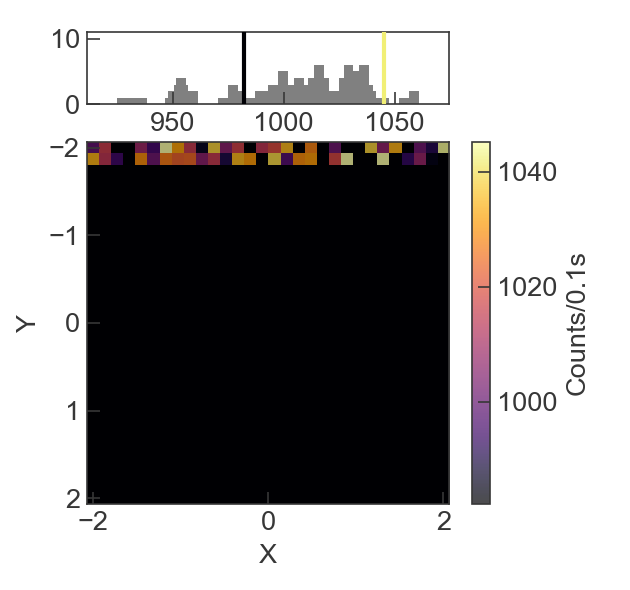

In [7]:
fig, data_figure = pl_dis(center=[0,0], coordinates_x=np.linspace(-2,2,30), \
                               coordinates_y=np.linspace(-2,2,30), exposure=0.1, wavelength=2)

In [8]:
data_figure.lorent()

In [456]:
data_figure = DataFigure(fig, selector)

In [9]:
data_figure.data

[masked_array(
   data=[[1000., 1016.,  948.,  954., 1009.,  996., 1058., 1032., 1015.,
           986., 1038., 1006., 1017.,  977., 1014., 1019., 1035.,  979.,
          1028.,  954., 1002.,  979.,  934., 1038., 1007., 1034.,  953.,
          1002.,  991., 1044.],
         [1034., 1014.,  995.,  925., 1029., 1002., 1027., 1023., 1024.,
          1006., 1015.,  990., 1035., 1031.,  952., 1039.,  998., 1029.,
          1031.,  972., 1018., 1053.,  982.,  959., 1061.,  958.,  993.,
          1008.,  985.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             

In [152]:
data_figure.save()

In [186]:
spl=299792458

In [189]:
spl/730.1-spl/(730.1+0.00097)

0.5455407084082253

In [489]:
data_figure.lorent(is_save=True)

popt = [ 7.59099993e+02  9.70344018e-04  1.01201560e+03 -1.63953400e+01], pcov = [[ 2.32065516e-10 -1.93709781e-11  1.13226898e-05  1.04750564e-06]
 [-1.93709781e-11  3.04309421e-09 -1.12651484e-03 -2.54887396e-04]
 [ 1.13226898e-05 -1.12651484e-03  1.13409149e+03 -5.46302023e+00]
 [ 1.04750564e-06 -2.54887396e-04 -5.46302023e+00  7.42833782e+01]]


<IPython.core.display.Javascript object>


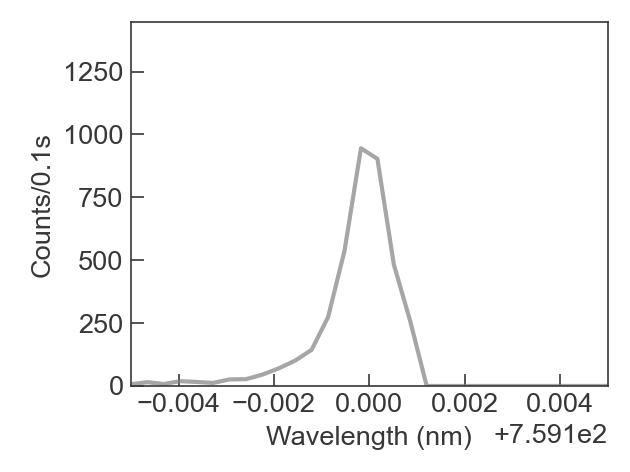

In [10]:
fig, data_figure = ple(np.linspace(759.1-0.005,759.1+0.005,30), exposure=0.1)

In [501]:
data_figure.clear()

In [11]:
data_figure.to_GHz()

In [12]:
data_figure.to_nm()

In [394]:
selector[2].x_center

759.1

In [12]:
for sel in selector:
    sel.set_active(False)

In [13]:
def print_all(fig):
    for ax in fig.axes:
        print('ax')
        for line in ax.lines:
            print('line', line)
        for patch in ax.patches:
            print('patch', patch)
        for text in ax.texts:
            print('text', text)
        for artist in ax.artists:
            print('art', artist)
        for collection in ax.collections:
            print('collection', collection)
        for image in ax.images:
            print('image', image)


In [14]:
def clear_all(fig):
    for ax in fig.axes:
        lines_to_remove = [line for line in ax.lines]
        patches_to_remove = [patch for patch in ax.patches]
        texts_to_remove = [text for text in ax.texts]
        

        for line in lines_to_remove:
            line.remove()
        for patch in patches_to_remove:
            patch.remove()
        for text in texts_to_remove:
            text.remove()

    fig.canvas.draw()

In [155]:
clear_all(fig)

In [112]:
fig.axes

[<AxesSubplot:xlabel='X', ylabel='Y'>, <Axes:>, <Axes:ylabel='Counts/s'>]

In [13]:
data_x, data_y, fig, axes, selector = pl_gui(center=[0,0], coordinates_x=np.linspace(-2,2,30), \
                               coordinates_y=np.linspace(-2,2,30), exposure=0.1, wavelength=2, fig=fig)

In [17]:
import sys
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QPushButton, QWidget
from PyQt5.QtCore import QThread, pyqtSignal, QObject
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import threading
import matplotlib
#matplotlib.use('Qt5Agg')
#matplotlib.rcParams.update(params_nbagg)

from PyQt5 import QtCore, QtWidgets
from PyQt5.QtWidgets import QHBoxLayout, QWidget, QPushButton, QLabel, QLineEdit, QDoubleSpinBox
from PyQt5.QtCore import QThread, pyqtSignal
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import time
from threading import Event

import io
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage



from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg


import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtCore import QThread, pyqtSignal, Qt
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QPushButton, QWidget
from PyQt5 import uic


class MplCanvas(FigureCanvasQTAgg):
    """
    labels = [xlabel, ylabel]
    """
    def __init__(self, parent=None, labels=None, mode=None):
        plt.close()
        self.fig = plt.figure()
        self.axes = self.fig.add_subplot(111)
        if labels is not None:
            self.axes.set_xlabel(labels[0])
            self.axes.set_ylabel(labels[1])
            
        if mode=='PL':
            
            line = self.axes.imshow(1e4*np.random.random((100, 100)), animated=True, cmap='inferno')
            cbar = self.fig.colorbar(line)
            cbar.set_label(labels[2])
        elif mode=='PLdis':
            
            divider = make_axes_locatable(self.axes)
            axright = divider.append_axes("top", size="20%", pad=0.25)
            cax = divider.append_axes("right", size="5%", pad=0.15)
            
            line = self.axes.imshow(1e4*np.random.random((100, 100)), animated=True, cmap='inferno')
            cbar = self.fig.colorbar(line, cax = cax)
            cbar.set_label(labels[2])
        elif mode=='PLE':
            self.axes.set_ylim(0, 1000)
            pass
            #line = self.axes.plot(np.linspace(730, 737, 100), animated=True)
            
        self.fig.tight_layout()
            
        super(MplCanvas, self).__init__(self.fig)


from matplotlib.widgets import RectangleSelector

class MainWindow(QMainWindow):
    def __init__(self, config_instances):
        super().__init__()
        self.config_instances = config_instances
        self.is_running = False
        self.selector_PLE = []
        self.selector_PL = []
        self.selector_Live = []
        self.is_wavelength_PL_flag = False
        self.is_wavelength_Live_flag = False
        self.data_figure_PL = None
        self.data_figure_PLE = None
        self.cur_plot = 'PL'
        self.is_fit = False
        self.spl = 299792458
        self.is_save_to_jupyter_flag = True

        uic.loadUi("PLandPLE.ui", self)


        
        self.widget_figure_PLE = self.findChild(QWidget, 'widget_figure_PLE')
        layout = QVBoxLayout(self.widget_figure_PLE)
        layout.setContentsMargins(0, 0, 0, 0)

        self.canvas_PLE = MplCanvas(self.widget_figure_PLE, labels=['Wavelength (nm)', 'Counts'], mode='PLE')
        layout.addWidget(self.canvas_PLE)
        
        
        self.widget_figure_PL = self.findChild(QWidget, 'widget_figure_PL')
        layout = QVBoxLayout(self.widget_figure_PL)
        layout.setContentsMargins(0, 0, 0, 0) 

        self.canvas_PL = MplCanvas(self.widget_figure_PL, labels=['X', 'Y', 'Counts'], mode='PLdis')
        layout.addWidget(self.canvas_PL)
        
        self.widget_figure_Live = self.findChild(QWidget, 'widget_figure_Live')
        layout = QVBoxLayout(self.widget_figure_Live)
        layout.setContentsMargins(0, 0, 0, 0) 

        self.canvas_Live = MplCanvas(self.widget_figure_Live, labels=['Data', 'Counts'], mode='PLE')
        layout.addWidget(self.canvas_Live)
        

                

        self.pushButton_start_PLE.clicked.connect(self.start_plot_PLE)
        self.pushButton_start_PL.clicked.connect(self.start_plot_PL)
        self.pushButton_start_Live.clicked.connect(self.start_plot_Live)
        self.pushButton_stop_PLE.clicked.connect(self.stop_and_show)
        self.pushButton_stop_PL.clicked.connect(self.stop_and_show)
        self.pushButton_stop_Live.clicked.connect(self.stop_and_show)
        
        self.radioButton_is_wavelength_PL.toggled.connect(self.is_wavelength_PL)
        self.radioButton_is_wavelength_Live.toggled.connect(self.is_wavelength_Live)
        self.checkBox_log.toggled.connect(self.is_save_to_jupyter)
        
        self.pushButton_wavelength_PL.clicked.connect(self.read_wavelength_PL)
        self.pushButton_wavelength_Live.clicked.connect(self.read_wavelength_Live)
        self.pushButton_range_PL.clicked.connect(self.read_range_PL)
        self.pushButton_range_PLE.clicked.connect(self.read_range_PLE)
        self.pushButton_lorent.clicked.connect(self.fit_lorent)
        self.pushButton_unit.clicked.connect(self.change_unit)
        self.pushButton_save_PL.clicked.connect(self.save_PL)
        self.pushButton_save_PLE.clicked.connect(self.save_PLE)
        self.pushButton_XY.clicked.connect(self.read_xy)
        self.show()
        
    def print_log(self, text):
        self.lineEdit_print.setText(text)
        
    def read_xy(self):
        if self.selector_PL == []:
            return
        _xy = self.selector_PL[1].xy #cross selector
        
        if _xy is not None:
                self.doubleSpinBox_X.setValue(_xy[0])
                self.doubleSpinBox_Y.setValue(_xy[1])
                self.doubleSpinBox_X_Live.setValue(_xy[0])
                self.doubleSpinBox_Y_Live.setValue(_xy[1])
                
    def is_save_to_jupyter(self, checked):
        if checked:
            self.is_save_to_jupyter_flag = True
        else:
            self.is_save_to_jupyter_flag = False
                
    def save_to_jupyter(self, fig):
        buffer = io.BytesIO()
        fig.savefig(buffer, format='png')
        buffer.seek(0)
        img_data = buffer.getvalue()
        img = PILImage.open(io.BytesIO(img_data))
        print(
        f"""
        {time.time()}
        """)
        display(IPImage(img_data, format='png'))
        fig.canvas.draw()
        
        
    def save_PL(self):
        if self.data_figure_PL is None:
            return
        self.data_figure_PL.save()
        
        if self.is_save_to_jupyter_flag:
            self.save_to_jupyter(self.canvas_PL.fig)
            
        self.print_log('save PL')
        
    def save_PLE(self):
        if self.data_figure_PLE is None:
            return
        self.data_figure_PLE.save()   
        
        if self.is_save_to_jupyter_flag:
            self.save_to_jupyter(self.canvas_PLE.fig)
            
        self.print_log('save PLE')
        
        
    def change_unit(self):
        if self.data_figure_PLE is None:
            return
        if self.data_figure_PLE.unit == 'nm':
            self.data_figure_PLE.to_GHz()
        else:
            self.data_figure_PLE.to_nm()
        
    def fit_lorent(self):
        if self.data_figure_PLE is None:
            return
        if self.is_fit:
            self.data_figure_PLE.clear()
            self.is_fit = False
        else:
            self.data_figure_PLE.lorent()
            self.is_fit = True
        
        
    def is_wavelength_PL(self, checked):
        if checked:
            self.doubleSpinBox_wavelength_PL.setDisabled(False)
            self.is_wavelength_PL_flag = True
        else:
            self.doubleSpinBox_wavelength_PL.setDisabled(True)
            self.is_wavelength_PL_flag = False
            
    def is_wavelength_Live(self, checked):
        if checked:
            self.doubleSpinBox_wavelength_Live.setDisabled(False)
            self.is_wavelength_Live_flag = True
        else:
            self.doubleSpinBox_wavelength_Live.setDisabled(True)
            self.is_wavelength_Live_flag = False
            
    def read_wavelength_PL(self):
        if self.selector_PLE == []:
            return
        _wavelength = self.selector_PLE[1].wavelength
        
        if _wavelength is not None:
            if self.data_figure_PLE.unit == 'nm':
                self.doubleSpinBox_wavelength_PL.setValue(_wavelength)
            else:
                self.doubleSpinBox_wavelength_PL.setValue(self.spl/_wavelength)
        #set double spin box to _wavelength
        
    def read_wavelength_Live(self):
        if self.selector_PLE == []:
            return
        _wavelength = self.selector_PLE[1].wavelength
        
        if _wavelength is not None:
            if self.data_figure_PLE.unit == 'nm':
                self.doubleSpinBox_wavelength_Live.setValue(_wavelength)
            else:
                self.doubleSpinBox_wavelength_Live.setValue(self.spl/_wavelength)
        
    def read_range_PL(self):
        if self.selector_PL == []:
            return
        xl, xh, yl, yh = self.selector_PL[0].range
        
        if xl is None:
            return
        
        self.doubleSpinBox_xl.setValue(xl)
        self.doubleSpinBox_xu.setValue(xh)
        self.doubleSpinBox_yl.setValue(yl)
        self.doubleSpinBox_yu.setValue(yh)
        
    def read_range_PLE(self):
        if self.selector_PLE == []:
            return
        xl, xh, yl, yh = self.selector_PLE[0].range
        
        if xl is None:
            return
        
        if self.data_figure_PLE.unit == 'nm':
            self.doubleSpinBox_wl.setValue(xl)
            self.doubleSpinBox_wu.setValue(xh)
        else:
            self.doubleSpinBox_wl.setValue(self.spl/xl)
            self.doubleSpinBox_wu.setValue(self.spl/xh)
        
        
    def read_data_PLE(self):
        for attr in ['exposure_PLE', 'wl', 'wu', 'step_PLE']: # Read from GUI panel
            value = getattr(self, f'doubleSpinBox_{attr}').value()
            setattr(self, attr, value)
            
        for attr in ['center', 'height', 'width']:
            value = self.config_instances.get(attr)
            setattr(self, attr, value)
            
    def read_data_PL(self):
        for attr in ['exposure_PL', 'xl', 'xu', 'yl', 'yu', 'step_PL', 'wavelength_PL']:
            value = getattr(self, f'doubleSpinBox_{attr}').value()
            #print(attr, value)
            setattr(self, attr, value)
            
    def read_data_Live(self):
        for attr in ['exposure_Live', 'many', 'wavelength_Live']:
            value = getattr(self, f'doubleSpinBox_{attr}').value()
            #print(attr, value)
            setattr(self, attr, value)
            

    def start_plot_PLE(self):
        self.cur_plot = 'PLE'
        self.stop_plot()
        self.is_running = True
                    
        
        self.read_data_PLE()
        
        data_x = np.arange(self.wl, self.wu, self.step_PLE)
        data_y = np.zeros(len(data_x))
        self.data_generator_PLE = PLEAcquire(exposure = self.exposure_PLE, \
                                         data_x=data_x, data_y=data_y, center=self.center, height=self.height, \
                                         width=self.width, bg=0)
        self.live_plot_PLE = PLELive(labels=['Wavelength (nm)', f'Counts/{self.exposure_PLE:.2f}s'], 
                                     update_time=1, data_generator=self.data_generator_PLE, data=[data_x, data_y],\
                                    fig=self.canvas_PLE.fig)
        

        self.live_plot_PLE.init_figure_and_data()
        
        
        self.timer = QtCore.QTimer()
        self.timer.setInterval(1000*self.live_plot_PLE.update_time)  # Interval in milliseconds
        self.timer.timeout.connect(self.update_plot)
        self.timer.start()
            
            
    def start_plot_PL(self):
        self.cur_plot = 'PL'
        self.stop_plot()
        self.is_running = True
            
            
        self.read_data_PL()
                
        center = [0,0]
        data_x = np.arange(self.xl, self.xu, self.step_PL) + center[0]
        data_y = np.arange(self.yl, self.yu, self.step_PL) + center[1]
        data_z = np.zeros((len(data_y), len(data_x)))
        # reverse for compensate x,y order of imshow
        if self.is_wavelength_PL_flag:
            _wavelength = self.wavelength_PL
        else:
            _wavelength = None
        self.data_generator_PL = PLAcquire(exposure = self.exposure_PL, data_x = data_x, data_y = data_y, \
                               data_z = data_z, center = [0,0], height = 1000, wavelength=_wavelength)
            
        self.live_plot_PL = PLGUILive(labels=['X', 'Y', f'Counts/{self.exposure_PL:.2f}s'], \
                        update_time=1, data_generator=self.data_generator_PL, data=[data_x, data_y, data_z],\
                                       fig=self.canvas_PL.fig)
        
        
        self.live_plot_PL.init_figure_and_data()
        
        self.timer = QtCore.QTimer()
        self.timer.setInterval(1000*self.live_plot_PL.update_time)  # Interval in milliseconds
        self.timer.timeout.connect(self.update_plot)
        self.timer.start()
        
            
    def start_plot_Live(self):
        self.cur_plot = 'Live'
        self.stop_plot()
        self.is_running = True
        self.read_data_Live()
        
        
        data_x = np.arange(self.many)
        data_y = np.zeros(len(data_x))
        
        if self.is_wavelength_Live_flag:
            _wavelength = self.wavelength_Live
        else:
            _wavelength = None
            
        self.data_generator_Live = LiveAcquire(exposure = self.exposure_Live, data_x=data_x, data_y=data_y, \
                                     height=1000, wavelength=_wavelength, is_finite=False)
        self.live_plot_Live = PLELive(labels=['Data', f'Counts/{self.exposure_Live:.2f}s'], \
                            update_time=0.05, data_generator=self.data_generator_Live, data=[data_x, data_y],\
                                         fig=self.canvas_Live.fig)
        
        
        self.live_plot_Live.init_figure_and_data()
        
        self.timer = QtCore.QTimer()
        self.timer.setInterval(1000*self.live_plot_Live.update_time)  # Interval in milliseconds
        self.timer.timeout.connect(self.update_plot)
        self.timer.start()
        
    def update_plot(self):
        
        attr = self.cur_plot
        live_plot_handle = getattr(self, f'live_plot_{attr}')

        if live_plot_handle.data_generator.is_alive() and self.is_running:

            live_plot_handle.update_figure()

        else:

            self.timer.stop()

            live_plot_handle.update_figure()  
            live_plot_handle.line.set_animated(False)                
            live_plot_handle.axes.set_autoscale_on(False)     
            setattr(self, f'selector_{attr}', live_plot_handle.choose_selector())
            live_plot_handle.stop()
            cur_fig = (getattr(self, f'canvas_{attr}')).fig
            cur_selector = getattr(self, f'selector_{attr}')
            setattr(self, f'data_figure_{attr}', DataFigure(cur_fig, cur_selector))
            
    
    def stop_plot(self):
        
        self.is_running = False
        attr = self.cur_plot
        
        for selector in getattr(self, f'selector_{attr}'):
            selector.set_active(False)
        setattr(self, f'selector_{attr}', []) #disable all selector
        setattr(self, f'data_figure_{attr}', None) #disable DataFigure
        
        if hasattr(self, 'timer'):
            self.timer.stop()
            
            
        if hasattr(self, 'live_plot_PLE') and self.live_plot_PLE is not None:
            #print('stop plot', 'PLE')
            self.live_plot_PLE.stop()
            
        if hasattr(self, 'live_plot_PL') and self.live_plot_PL is not None:
            #print('stop plot', 'PL')
            self.live_plot_PL.stop()
            
        if hasattr(self, 'live_plot_Live') and self.live_plot_Live is not None:
            #print('stop plot', 'Live')
            self.live_plot_Live.stop()
            
            
            
            
    def stop_and_show(self):
        self.is_running = False


            
    def closeEvent(self, event):
        self.stop_plot()
            
        event.accept()
        QtWidgets.QApplication.quit()  # Ensure application exits completely



def GUI(config_instances):
    """
    The function opens pyqt GUI for PLE, PL, live counts, and pulse control.
    Save button will also output data and figure to jupyter notebook.
   
    Examples
    --------
    >>> GUI()
    """
    
    app = QtCore.QCoreApplication.instance()
    #app.setStyle('Windows')
    if app is None:
        app = QtWidgets.QApplication(sys.argv)

    w = MainWindow(config_instances)
    app.exec_()

In [16]:
config_instances = {'center':737.1, 'height':10000, 'width':0.001}
GUI(config_instances)

AttributeError: 'NoneType' object has no attribute 'setStyle'